# ML Part Classification

In [1]:
from jupyter_core.paths import jupyter_path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from datetime import timedelta

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb # Our ML library

In [3]:
#Cross validation libraries
from sklearn.model_selection import TimeSeriesSplit

In [4]:
import joblib

In [5]:
os.chdir("C:/Users/oleg.kazanskyi/OneDrive - Danaher/Documents/Trading/ML_Part/EOD")
df_compact = pd.read_csv("full_cleaned_dataframe_2023.csv")
df_compact.shape

(527036, 55)

In [6]:
df_compact["date"] = df_compact["date"].apply(pd.to_datetime, errors='coerce')

In [7]:
df_copy = df_compact.copy()

In [8]:
df_compact.sort_values(by = "date", ascending = False, inplace = True)

In [9]:
display(df_compact.head(5))

,date,days_after_earnings_report,open,close,sector,industry,DE,CR,GM,ROA,...,10YB_YoY,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,Fed_SMA50_vector,Fed_SMA200_vector,Fed_SMA50_position,Fed_SMA200_position,Fed_SMA50_to_200_position,Pays_Divds
0,2023-03-17,17.0,136.89,133.18,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",0.373805,2.106405,0.551253,0.032237,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0
305,2023-03-17,51.0,132.33,130.26,Real Estate,Real Estate,2.014324,0.445624,0.704082,0.010637,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0
333,2023-03-17,51.0,76.29,75.67,Utilities,Utilities,0.579839,0.505338,0.756489,0.007972,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0
332,2023-03-17,44.0,46.32,45.32,Consumer Staples,"Food, Beverage & Tobacco",2.596846,0.837976,0.690537,0.072793,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0
331,2023-03-17,44.0,58.37,57.30,Industrials,Capital Goods,0.294917,1.023696,0.344595,0.003645,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_compact.reset_index(inplace = True)
df_compact.drop('index', axis = 1, inplace = True)
display(df_compact.head(5))

,date,days_after_earnings_report,open,close,sector,industry,DE,CR,GM,ROA,...,10YB_YoY,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,Fed_SMA50_vector,Fed_SMA200_vector,Fed_SMA50_position,Fed_SMA200_position,Fed_SMA50_to_200_position,Pays_Divds
0,2023-03-17,17.0,136.89,133.18,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",0.373805,2.106405,0.551253,0.032237,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-03-17,51.0,132.33,130.26,Real Estate,Real Estate,2.014324,0.445624,0.704082,0.010637,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-03-17,51.0,76.29,75.67,Utilities,Utilities,0.579839,0.505338,0.756489,0.007972,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-03-17,44.0,46.32,45.32,Consumer Staples,"Food, Beverage & Tobacco",2.596846,0.837976,0.690537,0.072793,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-03-17,44.0,58.37,57.30,Industrials,Capital Goods,0.294917,1.023696,0.344595,0.003645,...,56.240876,0.042431,-12.093456,-8.360444,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print(df_compact.columns)

Index(['date', 'days_after_earnings_report', 'open', 'close', 'sector',
       'industry', 'DE', 'CR', 'GM', 'ROA', 'DPR', 'Acc_Rec_Pay_Ration', 'ES',
       'DY', 'Piotroski_Score', 'PE', 'PEG_Forward', 'PEG_Backwards',
       'EPS_surprise', 'EPS_YoY_Growth', 'EPS_QoQ_frcst_diff',
       'EPS_1Y_exp_Change', 'YoY_CR', 'YoY_GM', 'YoY_DPR', 'YoY_ES',
       'YoY_Piotroski', 'YoY_PE', 'YoY_PEGF', 'YoY_PEGB', 'YoY_DY',
       'EPS_1Y_exp_Change_QoQ', 'future_15dprice_change',
       'future_30dprice_change', 'future_60dprice_change',
       'future_90dprice_change', 'future_120dprice_change',
       'future_150dprice_change', 'VIX_high', 'days_after_crisis', 'VIX_DoD',
       'VIX_WoW', 'VIX_MoM', 'stock', '10YBond', '10YB_YoY',
       '10YB_200MA_Vector', '10Y_Val_to_30MA', '10Y_Val_to_200MA',
       'Fed_SMA50_vector', 'Fed_SMA200_vector', 'Fed_SMA50_position',
       'Fed_SMA200_position', 'Fed_SMA50_to_200_position', 'Pays_Divds'],
      dtype='object')


In [12]:
df_compact.drop(['close','open'], axis = 1, inplace = True)

In [13]:
#Let's take the top 5% as the test df
y_vals = ["future_15dprice_change","future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"]
n_days = [15,30,60,90,120,150]
min_date_train = []

test_dfs_list = []
train_dfs_list = []
full_dfs_list = []

for i, j in enumerate(y_vals):
    n = 5
    num_rows = int(len(df_compact[df_compact[j].notnull()])*(n/100))
    df_full = df_compact[df_compact[j].notnull()]
    df_test = df_compact[df_compact[j].notnull()].iloc[:num_rows]
    df_train = df_compact[df_compact[j].notnull()].iloc[num_rows:]
    
    #Let's remove the data closest to the prediction date to make it close to a real world scenario
    max_date = df_train.date.max()
    max_date = df_train.date.max() - timedelta(days=n_days[i])
    max_date = max_date.strftime('%Y-%m-%d')
    df_train = df_train[df_train.date < max_date]
    
    min_date_train.append(df_train.date.min())

    #We can drop the date column as redundant now
    df_train.drop('date',axis = 1, inplace = True)
    df_test.drop('date',axis = 1, inplace = True)
    df_full.drop('date',axis = 1, inplace = True)
    
    test_dfs_list.append(df_test)
    train_dfs_list.append(df_train)
    full_dfs_list.append(df_full)
    
    
    print(f"Train data size for {n_days[i]} is {df_train.shape[0]} rows")
    print(f"Test data size for {n_days[i]}  is {df_test.shape[0]} rows")

Train data size for 15 is 490110 rows
Test data size for 15  is 26084 rows
Train data size for 30 is 480895 rows
Test data size for 30  is 25817 rows
Train data size for 60 is 459651 rows
Test data size for 60  is 25282 rows
Train data size for 90 is 439930 rows
Test data size for 90  is 24748 rows
Train data size for 120 is 420213 rows
Test data size for 120  is 24214 rows
Train data size for 150 is 399573 rows
Test data size for 150  is 23681 rows


In [14]:
#For the simplicity of analysis we will work with one train dataframe but apply transformations to all the dataframes in the list
df_train = train_dfs_list[0]

cols_num = df_train.select_dtypes([np.number]).columns
cols_str = df_train.select_dtypes('object').columns

### Building a classificator

Ok, we dealt with the numeric prediction of the stock prices movement.

At the same time after seeing the results it made me rethink the purpose.

I am not a trader and the model I am building doesn't have a purpose of daily stocks exchange.

What I want to achieve is to find a stock that with high probability will grow in the next foreseeable future, hold it for a while and sell it with a profit.

Considering this maybe we shouldn't solve the regression problem, but make it a classification problem instead.

To make it the classification problem we would need to replace all price times the prices are going up to 1 and down to zerows.

At the same time I want my model to cover the risks, so let's add the risk factor of loosing a bet and make the range wider.
We will change values to 1 when the price goes up on the level of 3rd percentile for every time range prediction

In [15]:
min_15d_threshold =  5#4.112
min_30d_threshold =  7#6.18
min_60d_threshold =  10#9.25
min_90d_threshold =  12#11.53
min_120d_threshold = 14#13.77
min_150d_threshold =  16#15.95

list_of_thresholds = [min_15d_threshold,min_30d_threshold,min_60d_threshold,min_90d_threshold,min_120d_threshold,min_150d_threshold]

Make the changes to the dataset

In [16]:
targets_all = ["future_15dprice_change","future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"]
periods = ["15d","30d","60d","90d","120d","150d"]
#df_compact_reserve = df_compact.copy()
#Creating a copy of the list with the dataframes
'''full_dfs_list_copy = []
train_dfs_list_copy = []
test_dfs_list_copy = []
for i, j in enumerate(targets_all):
    full = full_dfs_list[i].copy()
    train = train_dfs_list[i].copy()
    test = test_dfs_list[i].copy()
    full_dfs_list_copy.append(full)
    train_dfs_list_copy.append(train)
    test_dfs_list_copy.append(test)'''
    

for i, j in enumerate(targets_all):
    #df_compact.loc[df_compact[j]<list_of_thresholds[i], j] = 0
    #df_compact.loc[df_compact[j]>=list_of_thresholds[i], j] = 1
    full_dfs_list[i].loc[full_dfs_list[i][j]<list_of_thresholds[i], j] = 0
    full_dfs_list[i].loc[full_dfs_list[i][j]>=list_of_thresholds[i], j] = 1
    train_dfs_list[i].loc[train_dfs_list[i][j]<list_of_thresholds[i], j] = 0
    train_dfs_list[i].loc[train_dfs_list[i][j]>=list_of_thresholds[i], j] = 1
    test_dfs_list[i].loc[test_dfs_list[i][j]<list_of_thresholds[i], j] = 0
    test_dfs_list[i].loc[test_dfs_list[i][j]>=list_of_thresholds[i], j] = 1

## Cross validation time data

In [17]:
df_train = full_dfs_list[1]
df_train = df_train.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_train = df_train[df_train["future_30dprice_change"].notna()]

In [18]:
df_train.reset_index(inplace = True)
df_train.drop('index', axis = 1, inplace = True)
df_train.head(5)

,days_after_earnings_report,sector,industry,DE,CR,GM,ROA,DPR,Acc_Rec_Pay_Ration,ES,...,10YB_YoY,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,Fed_SMA50_vector,Fed_SMA200_vector,Fed_SMA50_position,Fed_SMA200_position,Fed_SMA50_to_200_position,Pays_Divds
0,32.0,Financials,Diversified Financials,0.078120,5.000000,0.491301,0.011791,0.540779,1.003883,1.227998,...,88.426854,0.157312,5.517416,5.285509,-0.048073,-0.048073,0.005298,0.019456,-0.013888,0.0
1,7.0,Industrials,Capital Goods,0.340916,1.483294,0.214473,0.009832,0.203252,3.699875,0.938940,...,88.426854,0.157312,5.517416,5.285509,-0.048073,-0.048073,0.005298,0.019456,-0.013888,0.0
2,32.0,Financials,Banks,0.072654,0.303792,0.700024,0.002580,0.350416,0.479658,2.292973,...,88.426854,0.157312,5.517416,5.285509,-0.048073,-0.048073,0.005298,0.019456,-0.013888,0.0
3,12.0,Communication Services,Media & Entertainment,0.045693,2.377994,0.535267,0.037299,0.000000,7.850624,1.061685,...,88.426854,0.157312,5.517416,5.285509,-0.048073,-0.048073,0.005298,0.019456,-0.013888,1.0
4,104.0,Information Technology,Software & Services,0.143933,2.378054,0.868856,0.015576,0.001417,10.000000,0.400279,...,88.426854,0.157312,5.517416,5.285509,-0.048073,-0.048073,0.005298,0.019456,-0.013888,0.0


In [19]:
df_train.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)

In [20]:
df_train.dropna(inplace = True)
df_train.reset_index(inplace = True)
df_train.drop('index', axis = 1, inplace = True)

In [21]:
y_train = df_train["future_30dprice_change"]
x_train = df_train.drop("future_30dprice_change", axis = 1)
x_train.index

RangeIndex(start=0, stop=516344, step=1)

In [22]:
from sklearn.model_selection import ParameterGrid

n = 5
tscv = TimeSeriesSplit(n_splits=n, test_size=30000, gap=round(11050,0))

'''le = LabelEncoder()
le.fit(x_train["sector"])
x_train["sector"] = le.transform(x_train["sector"])

param_search  = {'boosting_type ':['gbdt', 'dart', 'rf'], 
              'num_leaves':[10, 40, 100, 150], 
              'max_depth' :[-1, 40, 100, 150],
              'learning_rate' : [0.001, 0.01, 0,1],
              'n_estimators' : [50, 100, 200]}


tscv = TimeSeriesSplit(n_splits=n, test_size=22000, gap=round(11050,0))
clf = lgb.LGBMClassifier(random_state=42)     

gsearch = GridSearchCV(estimator=clf, cv=tscv,
                        param_grid=param_search,
                        scoring = 'precision', 
                        n_jobs = 10,
                        verbose = 3)
gsearch.fit(x_train, y_train)'''


aucs = []
precs = []

for i, (train_index, val_idx) in enumerate(tscv.split(df_train)):
        print(f"======= Fold {i} ========")
        #print(f"  Train: index={min(train_index)} : {max(train_index)}")
        #print(f"  Test:  index={min(val_idx)} : {max(val_idx)}")

        X_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        print(y_tr[y_tr == 1].count() / y_tr.count())
        
        X_val = x_train.loc[val_idx]
        y_val = y_train.loc[val_idx] 
        print(y_val[y_val == 1].count() / y_tr.count())

        le = LabelEncoder()
        le.fit(X_tr["sector"])
        X_tr["sector"] = le.transform(X_tr["sector"])
        X_val["sector"] = le.transform(X_val["sector"])

        # Fit Model on Train
        clf = lgb.LGBMClassifier(random_state=42, n_jobs = 10, n_estimators = 100)     
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        #print(pred.sum())
        #if pred.sum() == 0:
        
        #Calculation of the proportion  1 to 0
        proportion_of_ones = y_tr[y_tr == 1].count() / y_tr.count()

        pred_prob = clf.predict_proba(X_val)[:, 1]
        f_one_score = f1_score(y_val, pred)
        precision = precision_score(y_val, pred, pos_label=1, average='binary')
        auc_score = roc_auc_score(y_val, pred_prob)

        print(f"Our F1 on the validation set is {f_one_score:0.4f}, precision is {precision:0.4f}, and AUC is {auc_score:0.4f}")
        aucs.append(auc_score)
        oof_auc = np.mean(aucs)
        precs.append(precision)
        precs_auc = np.mean(precs)

        if i == n-1:
            print(f'\n Our out of fold AUC score is {oof_auc:0.4f} and precision is {precs_auc:0.4f} \n\n')

======= Fold 0 ========
0.21886662876378435
0.023273683203206358
Our F1 on the validation set is 0.0493, precision is 0.6503, and AUC is 0.6154
======= Fold 1 ========
0.22617533623674388
0.008912674477152513
Our F1 on the validation set is 0.0012, precision is 0.1000, and AUC is 0.6063
======= Fold 2 ========
0.2171521861620924
0.013402553371828151
Our F1 on the validation set is 0.0029, precision is 0.8000, and AUC is 0.5792
======= Fold 3 ========
0.21385870907759816
0.007303040238583947
Our F1 on the validation set is 0.1631, precision is 0.3746, and AUC is 0.7239
======= Fold 4 ========
0.21071378978064104
0.01583440986000244
Our F1 on the validation set is 0.0000, precision is 0.0000, and AUC is 0.6065

 Our out of fold AUC score is 0.6263 and precision is 0.3850 




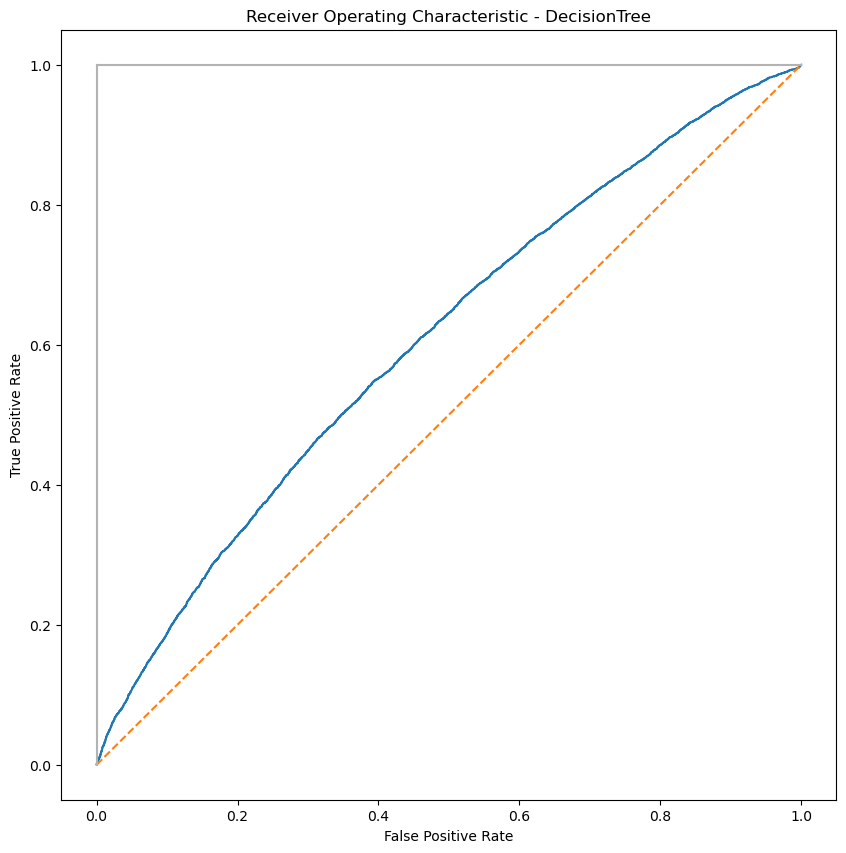

In [23]:
import scikitplot as skplt
import matplotlib.pyplot as plt

def plot_auc(y_proba, y_val):
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_val, y_proba)

    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_auc(pred_prob,y_val)

print(gsearch.best_estimator_)
print(gsearch.best_params_)
print(gsearch.scorer_)
print(gsearch.best_score_)

#df_train_copy = df_train.copy()
df_train = df_train_copy.copy()
df_train.drop(['stock','industry'], axis = 1, inplace = True)

## Trying XGBoost

======= Fold 0 ========
Our F1 on the validation set is 0.0105, precision is 0.4595, and AUC is 0.5946
======= Fold 1 ========
Our F1 on the validation set is 0.0068, precision is 0.2545, and AUC is 0.5363
======= Fold 2 ========
Our F1 on the validation set is 0.0958, precision is 0.1820, and AUC is 0.6118
======= Fold 3 ========
Our F1 on the validation set is 0.1730, precision is 0.3102, and AUC is 0.5320
======= Fold 4 ========
Our F1 on the validation set is 0.0165, precision is 0.3390, and AUC is 0.5819

 Our out of fold AUC score is 0.5988 and precision is 0.3470 




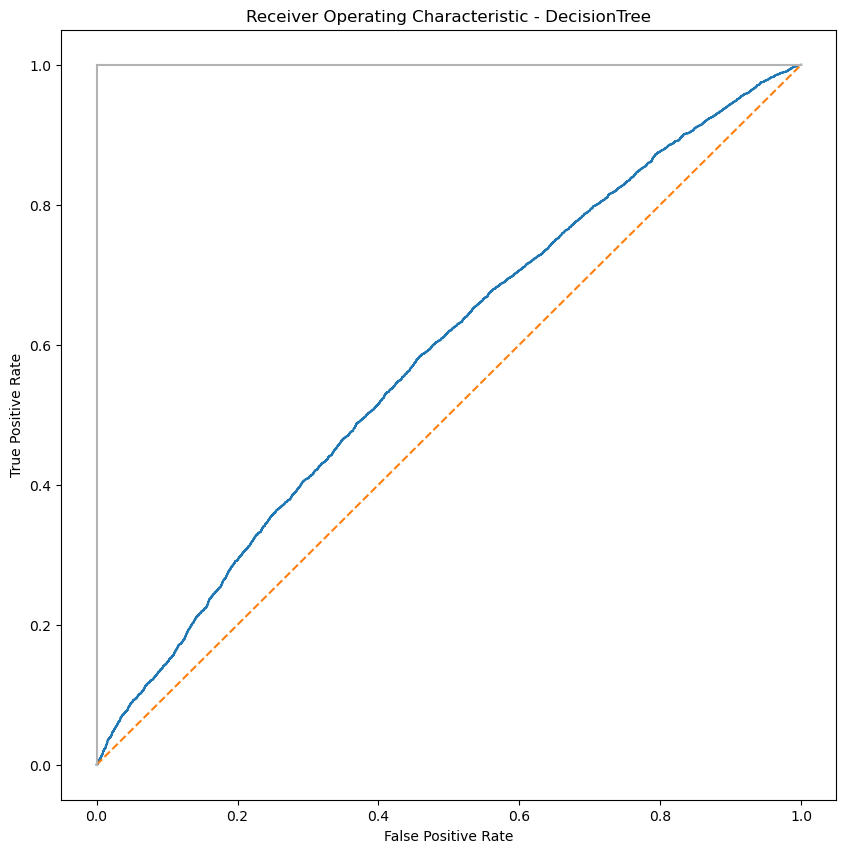

"aucs = []\nprecs = []\n\nparam_search  = {'boosting_type ':['gbdt', 'dart', 'rf'], \n              'num_leaves':[10, 40, 100, 150], \n              'max_depth' :[-1, 40, 100, 150],\n              'learning_rate' : [0.001, 0.01, 0,1],\n              'n_estimators' : [50, 100, 200]}\n\n\ntscv = TimeSeriesSplit(n_splits=n, test_size=22000, gap=round(11050,0))\nclf = lgb.XGBClassifier(random_state=42)     \n\ngsearch = GridSearchCV(estimator=clf, cv=tscv,\n                        param_grid=param_search,\n                        scoring = 'precision', \n                        n_jobs = 10,\n                        verbose = 3)\ngsearch.fit(x_train, y_train)"

In [24]:
from xgboost import XGBClassifier

t = pd.get_dummies(df_train['sector'], drop_first=True)
df_train.drop('sector', axis = 1, inplace = True)
df_train = df_train.join(t)

y_train = df_train["future_30dprice_change"]
x_train = df_train.drop("future_30dprice_change", axis = 1)

n = 5
tscv = TimeSeriesSplit(n_splits=n, test_size=22000, gap=round(11050,0))

for i, (train_index, val_idx) in enumerate(tscv.split(df_train)):
        print(f"======= Fold {i} ========")
        #print(f"  Train: index={min(train_index)} : {max(train_index)}")
        #print(f"  Test:  index={min(val_idx)} : {max(val_idx)}")

        X_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]

        X_val = x_train.loc[val_idx]
        y_val = y_train.loc[val_idx] 


        # Fit Model on Train
        clf = XGBClassifier(objective= 'binary:logistic',
                            nthread=4,
                            seed=42
                        )     
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        #print(pred.sum())
        #if pred.sum() == 0:
        
        #Calculation of the proportion  1 to 0
        proportion_of_ones = y_tr[y_tr == 1].count() / y_tr.count()

        pred_prob = clf.predict_proba(X_val)[:, 1]
        f_one_score = f1_score(y_val, pred)
        precision = precision_score(y_val, pred, pos_label=1, average='binary')
        auc_score = roc_auc_score(y_val, pred_prob)

        print(f"Our F1 on the validation set is {f_one_score:0.4f}, precision is {precision:0.4f}, and AUC is {auc_score:0.4f}")
        aucs.append(auc_score)
        oof_auc = np.mean(aucs)
        precs.append(precision)
        precs_auc = np.mean(precs)

        if i == n-1:
            print(f'\n Our out of fold AUC score is {oof_auc:0.4f} and precision is {precs_auc:0.4f} \n\n')
            plot_auc(pred_prob,y_val)



'''aucs = []
precs = []

param_search  = {'boosting_type ':['gbdt', 'dart', 'rf'], 
              'num_leaves':[10, 40, 100, 150], 
              'max_depth' :[-1, 40, 100, 150],
              'learning_rate' : [0.001, 0.01, 0,1],
              'n_estimators' : [50, 100, 200]}


tscv = TimeSeriesSplit(n_splits=n, test_size=22000, gap=round(11050,0))
clf = lgb.XGBClassifier(random_state=42)     

gsearch = GridSearchCV(estimator=clf, cv=tscv,
                        param_grid=param_search,
                        scoring = 'precision', 
                        n_jobs = 10,
                        verbose = 3)
gsearch.fit(x_train, y_train)'''

## Trying SVM


New data preparation

In [25]:
df_train = full_dfs_list[1]
df_train = df_train.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_train = df_train[df_train["future_30dprice_change"].notna()]

df_train.dropna(inplace = True)
df_train.reset_index(inplace = True)
df_train.drop('index', axis = 1, inplace = True)

df_train.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)
y_train = df_train["future_30dprice_change"]
x_train = df_train.drop("future_30dprice_change", axis = 1)
x_train.index

RangeIndex(start=0, stop=516344, step=1)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

t = pd.get_dummies(df_train['sector'], drop_first=True)
df_train.drop('sector', axis = 1, inplace = True)
df_train = df_train.join(t)

y_train = df_train["future_30dprice_change"]
x_train = df_train.drop("future_30dprice_change", axis = 1)

n = 3
tscv = TimeSeriesSplit(n_splits=n, test_size=22000, gap=round(11050,0))



for i, (train_index, val_idx) in enumerate(tscv.split(df_train)):
        print(f"======= Fold {i} ========")
        #print(f"  Train: index={min(train_index)} : {max(train_index)}")
        #print(f"  Test:  index={min(val_idx)} : {max(val_idx)}")

        X_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]

        X_val = x_train.loc[val_idx]
        y_val = y_train.loc[val_idx] 
        
        scaler = StandardScaler()
        scaler.fit(X_tr)
        X_tr = scaler.fit_transform(X_tr)
        X_val = scaler.transform(X_val)
        
        proportion_of_ones = y_val[y_val == 1].count() / y_val.count()
        proportion_of_zeroes = y_val[y_val == 0].count() / y_val.count()
        # Fit Model on Train
        
        weights = {0:proportion_of_zeroes, 1:proportion_of_ones}
        print("1:",proportion_of_ones,"; 0:",proportion_of_zeroes)
        clf = SVC(gamma='scale', class_weight=weights) 
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        #print(pred.sum())
        #if pred.sum() == 0:
        
        #Calculation of the proportion  1 to 0
        proportion_of_ones = y_tr[y_tr == 1].count() / y_tr.count()

        #pred_prob = clf.predict_proba(X_val)[:, 1]
        f_one_score = f1_score(y_val, pred)
        precision = precision_score(y_val, pred, pos_label=1, average='binary')
        #auc_score = roc_auc_score(y_val, pred_prob)

        print(f"Our F1 on the validation set is {f_one_score:0.4f}, precision is {precision:0.4f}")    
        precs.append(precision)
        precs_auc = np.mean(precs)

        if i == n-1:
            print(f'\n Our out of fold precision is {precs_auc:0.4f} \n\n')

======= Fold 0 ========
1: 0.11890909090909091 ; 0: 0.881090909090909
Our F1 on the validation set is 0.0000, precision is 0.0000
======= Fold 1 ========
1: 0.20881818181818182 ; 0: 0.7911818181818182


In [ ]:
print(np.count_nonzero(pred))
print(len(pred))

In [ ]:
ytyt

#Creating the x, y variables 
y_train = df_train["future_30dprice_change"]
y_test = df_test["future_30dprice_change"]

x_train = df_train.drop("future_30dprice_change", axis = 1)
x_test = df_test.drop("future_30dprice_change", axis = 1)

lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
lgbm.fit(x_train, y_train)#, categorical_feature=['sector'])

#predicting on test set
ypred=lgbm.predict(x_test)
ypred_prob = lgbm.predict_proba(x_test)[:, 1]

#calculating accuracy
precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
AUC = round(roc_auc_score(y_test, ypred_prob),2)
print(f"Precision of prediction:{precision:0.2f}, and the AUC is: {AUC:0.2f}")

cm = confusion_matrix(y_test, ypred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### We got increase of precision from 49% in the regression model to 50% in classification model.
I know that we are kind of comparing apples to oranges, but with a target we have in mind this is a great result without model tuning and little efforts.

#### Let's find the best timeframe to invest testing the classification for all the prediction length

In [ ]:
precisions_list = []
AUC_list = []
feature_importances = []
list_of_classification_models = []
list_of_test_df = []
list_of_ypred = []
list_of_ypred_proba = []

for j, i in enumerate(targets_all):
    remove_redundant_list = list(targets_all)
    remove_redundant_list.remove(i)

    #df_compact_temp = df_compact.drop(remove_redundant_list,axis = 1)
    #df_compact_temp = df_compact_temp[df_compact_temp[i].notna()]
    #df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)
    df_train, df_test = train_dfs_list[j], test_dfs_list[j]
    df_train = df_train.drop(remove_redundant_list,axis = 1)
    df_train = df_train[df_train[i].notna()]
    df_test = df_test.drop(remove_redundant_list,axis = 1)
    df_test = df_test[df_test[i].notna()]

    df_train.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)
    df_test.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)
    list_of_test_df.append(df_test)

    le = LabelEncoder()
    le.fit(df_train["sector"])
    df_train["sector"] = le.transform(df_train["sector"])
    df_test["sector"] = le.transform(df_test["sector"])

    #Creating the x, y variables 
    y_train = df_train[i]
    y_test = df_test[i]

    x_train = df_train.drop(i, axis = 1)
    x_test = df_test.drop(i, axis = 1)

    lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
    lgbm.fit(x_train, y_train, categorical_feature=['sector'])
    list_of_classification_models.append(lgbm)

    #predicting on test set
    ypred=lgbm.predict(x_test)
    ypred_prob = lgbm.predict_proba(x_test)[:, 1]
    list_of_ypred.append(ypred)
    list_of_ypred_proba.append(ypred_prob)

    #calculating accuracy
    precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
    AUC = round(roc_auc_score(y_test, ypred_prob),2)
    print("\n"*3+"="*50+"\n"+f"Precision of prediction for {periods[j]}:{precision:0.2f}")
    print("\n"+f"AUC of this classifier for {periods[j]}:{AUC:0.2f}")
    precisions_list.append(precision)
    AUC_list.append(AUC)

    cm = confusion_matrix(y_test, ypred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                     index=['Actual Negative:0', 'Actual Positive:1'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()
    
    feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
    feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
    print(feature_imp.sort_values(by='Value, %', ascending=False)[:20])
    feature_importances.append(feature_imp[["Feature", "Value, %"]])

### Let's summarize the precision level we got for every record

In [ ]:
precisions_list = [round(x*100,2) for x in precisions_list]
AUC_list = [round(x*100,2) for x in AUC_list]

precisions_compare_dt = {"Precision achieved":precisions_list,"AUC achieved":AUC_list}
precisions_compare_df = pd.DataFrame(precisions_compare_dt, index = periods)
precisions_compare_df.index.name = "Forecasted Period, days"

print(precisions_compare_df)

The max precision we achieved is for 30days prediction timeframe and is 69%.

We also need to remember that to be secure we are not predictiong when the price goes up, but when it goes up for more than 6% in case of 30 days and 4.1% in case of 15 days prediction.

I trully wonder what might be the total precision if we compare it with the zero level.
We have indexes untouched so lets compare.

In [ ]:
# first let's create a new column with the 30days prediction classifier: 0 when price dropped and 1 when it's increased.
model_number = 2 # Equal to 60 days
df_30d_train = train_dfs_list[model_number]
df_30d_test = test_dfs_list[model_number]

df_30d_train.loc[df_30d_train["future_60dprice_change"]<0.1, "60dprice_change_classification"] = 0
df_30d_train.loc[df_30d_train["future_60dprice_change"]>=0.1, "60dprice_change_classification"] = 1
df_30d_test.loc[df_30d_test["future_60dprice_change"]<0.1, "60dprice_change_classification"] = 0
df_30d_test.loc[df_30d_test["future_60dprice_change"]>=0.1, "60dprice_change_classification"] = 1

In [ ]:
print(df_30d_test.shape)
len(list_of_ypred[model_number])

In [ ]:
#let's join prediction result to the test dataframe and get indexes
df_prediction = df_30d_test.copy()
df_prediction["prediction"] = list_of_ypred[model_number]
df_prediction = df_prediction["prediction"]

In [ ]:
#let's connect prediction result by indexes to the main dataframe
df_30_compare =  df_30d_test[["future_60dprice_change","60dprice_change_classification"]]
df_30_compare = df_30_compare.join(df_prediction, how = 'left')
df_30_compare = df_30_compare[df_30_compare["prediction"].notnull()]

In [ ]:
# Now let's see how many negative values were really predicted as positive
df_30_compare = df_30_compare[["60dprice_change_classification","prediction"]].groupby("60dprice_change_classification").sum()
df_30_compare["Value, %"] = (df_30_compare['prediction'] / df_30_compare['prediction'].sum()) * 100
df_30_compare

## 86% PRECISION!!!!!

We achieved a great precision with a tested results.

The only issue here is the number of required deals is close to 2500.

The length of the dataset is about 3 months of data, that means implementing the strategy requires making about 800 deals a month.
To make outcome feasible a minimum bet should be about 1000USD so the starting capital should be 800K USD.

It is not a feasible amount for me personally.

I want to find out if increasing of the threshold that our model uses to make a classification about the model, can actually reduce the number of deals and increase the precision even further.

### Let's try to increase the threshold and check if we can get higher

In [ ]:
#let's join prediction result to the test dataframe and get indexes
df_prediction = df_30d_test.copy()
df_prediction["prediction"] = list_of_ypred[model_number]
df_prediction["prediction_proba"] = list_of_ypred_proba[model_number]
df_prediction = df_prediction[["prediction","prediction_proba"]]

#let's connect prediction result by indexes to the main dataframe
df_30_compare =  df_30d_test[["future_60dprice_change","60dprice_change_classification"]]
df_30_compare = df_30_compare.join(df_prediction, how = 'left')
df_30_compare = df_30_compare[df_30_compare["prediction"].notnull()]

Creating a function that adds new conditinal columns to the dataset

In [ ]:

def add_proba_column(dataframe, old_col, new_col, threshold):
    dataframe.loc[dataframe[old_col] >= threshold, new_col] = 1
    dataframe.loc[dataframe[old_col] < threshold, new_col] = 0
    return dataframe

Adding columns

In [ ]:
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_55",0.55)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_60",0.60)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_65",0.65)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_70",0.70)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_75",0.75)
df_30_compare = add_proba_column(df_30_compare,"prediction_proba","pred_80",0.80)

Add a function to display pivot tables based on a column

In [ ]:
def pivot_precision(dataframe, real_class, prediction_class):
    dataframe = dataframe[[real_class,prediction_class]].groupby(real_class).sum()
    dataframe["Value, %"] = (dataframe[prediction_class] / dataframe[prediction_class].sum()) * 100
    display(dataframe)
    print('\n')

In [ ]:
predicitons_list_str = ["pred_55","pred_60","pred_65","pred_70","pred_75","pred_80"]

for i in predicitons_list_str:
    pivot_precision(df_30_compare, "60dprice_change_classification", i)

Great, we got 2 last options with the threshold above 75% that allow us to make it works with the much lower budgets.

I will works with a model with a modified threshold at 80% level as it allows to work with about 25K USD budget.

Let's save the model and label encoder to the joblib files

Let's relearn our model based on all he data before saving

In [ ]:
feature_importances = []
list_of_classification_models = []

list_of_ypred = []
list_of_ypred_proba = []

for j, i in enumerate(targets_all):
    remove_redundant_list = list(targets_all)
    remove_redundant_list.remove(i)

    df_full = full_dfs_list_copy[j]
    df_full = df_full.drop(remove_redundant_list,axis = 1)
    df_full = df_full[df_full[i].notna()]


    df_full.drop(["stock","industry","days_after_crisis"], axis = 1, inplace = True)

    le = LabelEncoder()
    le.fit(df_full["sector"])
    df_full["sector"] = le.transform(df_full["sector"])

    #Creating the x, y variables 
    y_train = df_full[i]
    x_train = df_full.drop(i, axis = 1)


    lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
    lgbm.fit(x_train, y_train, categorical_feature=['sector'])
    list_of_classification_models.append(lgbm)
   
    feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
    feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
    print(feature_imp.sort_values(by='Value, %', ascending=False)[:20])
    feature_importances.append(feature_imp[["Feature", "Value, %"]])

#Saving the label encoder
filename = 'C:/Users/oleg.kazanskyi/OneDrive - Danaher/Documents/Trading/Models/label_encoder_012023.joblib'
joblib.dump(le, filename)

#Saving the models
for i, period in enumerate(periods):
    folder = 'C:/Users/oleg.kazanskyi/OneDrive - Danaher/Documents/Trading/Models/'
    full_path = os.path.join(folder,period+"_model.joblib")
    joblib.dump(list_of_classification_models[i], full_path)